# Figure 3D/E/F, NCO recombination parameters

## Setup

In [1]:
%run ../../shared_setup.ipynb

docker image cggh/biipy:v1.6.0


In [2]:
# load variation data
sample_exclusions = dup_samples.copy()
for cross in excessive_recomb_samples:
    sample_exclusions[cross] += excessive_recomb_samples[cross]

callsets = load_callsets(COMBINED_CALLSET_FN_TEMPLATE, 
                         sample_exclusions=sample_exclusions, 
                         variant_filter='FILTER_PASS',
                         call_filter=combined_conf_calls)

samples = {cross: callsets[cross]['calldata'].dtype.names
           for cross in CROSSES}
progeny = {cross: samples[cross][2:] for cross in CROSSES}
n_progeny = {cross: len(progeny[cross]) for cross in CROSSES}
print(n_progeny)
print(np.sum(list(n_progeny.values())))

2016-03-08 18:07:59.109120 :: loading /data/plasmodium/pfalciparum/pf-crosses/data/public/20141022/3d7_hb3.combined.final.npz
2016-03-08 18:07:59.402186 :: filter variants: excluding 157 (0.4%) retaining 42087 (99.6%) of 42244 variants
2016-03-08 18:07:59.420460 :: filter samples: excluding ['C01/PG0062-C/ERR019070', 'C02/PG0053-C/ERR019067', 'C02/PG0055-C/ERR019066', 'C02/PG0056-C/ERR019068'] including ['3D7/PG0051-C/ERR019061', 'HB3/PG0052-C/ERR019054', 'C01/PG0065-C/ERR019064', 'C02/PG0067-C/ERR019073', 'C03/PG0066-C/ERR019072', 'C04/PG0061-C/ERR019059', 'C05/PG0068-C/ERR019065', 'C06/PG0069-C/ERR019055', 'C07/PG0070-C/ERR019056', 'C08/PG0071-C/ERR019074', 'C09/PG0072-C/ERR019057', 'C10/PG0063-C/ERR019060', 'C11/PG0064-C/ERR019071', 'C12/PG0058-C/ERR019063', 'C13/PG0054-C/ERR019062', 'C14/PG0060-C/ERR019058', 'C15/PG0057-C/ERR019069']
2016-03-08 18:07:59.468446 :: filter calls: excluding 2216 (0.3%) retaining 713263 (99.7%) of 715479 calls
2016-03-08 18:07:59.469582 :: loading /data

{'7g8_gb4': 27, 'hb3_dd2': 34, '3d7_hb3': 15}
76


In [3]:
tbl_nco = (etl
    .frompickle(os.path.join(PUBLIC_DIR, 'tbl_conversion_tracts.pickle'))
    .eq('tract_type', 'NCO')
    # exclude the really long outliers
    .lt('tract_length_min', 18000)
)
display_with_nrows(tbl_nco, caption='NCO tracts')
df_nco = tbl_nco.todataframe()

0|sample,1|cross,2|chrom,3|tract_start_min,4|tract_start_mid,5|tract_start_max,6|tract_stop_min,7|tract_stop_mid,8|tract_stop_max,9|tract_length_min,10|tract_length_mid,11|tract_length_max,12|tract_support,13|tract_is_complex,14|tract_blocks,15|co_pos_mid,16|co_pos_min,17|co_pos_max,18|co_pos_range,19|tract_type
1BB5/PG0023-C/ERR015449,hb3_dd2,b'Pf3D7_02_v3',551191,551710,552230,553769,554132,554496,1539,2422,3305,5,False,1,None,None,None,None,NCO
1BB5/PG0023-C/ERR015449,hb3_dd2,b'Pf3D7_08_v3',1293542,1294381,1295221,1296788,1297035,1297283,1567,2654,3741,4,False,1,None,None,None,None,NCO
1BB5/PG0023-C/ERR015449,hb3_dd2,b'Pf3D7_09_v3',950476,951138,951801,954256,954735,955215,2455,3597,4739,4,True,3,None,None,None,None,NCO
1BB5/PG0023-C/ERR015449,hb3_dd2,b'Pf3D7_12_v3',331487,331820,332154,336886,337497,338108,4732,5677,6621,7,False,1,None,None,None,None,NCO
1BB5/PG0023-C/ERR015449,hb3_dd2,b'Pf3D7_13_v3',756601,756957,757313,760183,761269,762355,2870,4312,5754,9,False,1,None,None,None,None,NCO


### Simulate random uniform/geometric NCOs

In [4]:
def simulate_nco(phi, sim_factor=10):
    tbls_nco_sim = [simulate_random_uniform_non_crossovers(len(progeny[cross])*sim_factor, callsets[cross], phi).addfield('cross', cross)
                    for cross in CROSSES]
    tbl_nco_sim = etl.cat(*tbls_nco_sim)
    return tbl_nco_sim.todataframe()

In [5]:
# simulation based on uniform location and geometric length
# N.B., don't want to have to repeat this if possible
nco_sim_fn = os.path.join(PUBLIC_DIR, 'nco_sim.dataframe.pickle')
if not os.path.exists(nco_sim_fn):
    log('simulating')
    df_nco_sim = simulate_nco(phi=.9993, sim_factor=5000)
    log('saving', nco_sim_fn)
    df_nco_sim.to_pickle(nco_sim_fn)
else:
    log('loading', nco_sim_fn)
    df_nco_sim = pandas.read_pickle(nco_sim_fn)

2016-03-08 18:08:04.059834 :: loading /data/plasmodium/pfalciparum/pf-crosses/data/public/20141022/nco_sim.dataframe.pickle


In [6]:
# discovery rates
nco_discovery_rate = dict()
for cross in CROSSES:
    n = np.count_nonzero(df_nco_sim.cross == cross)
    n_discovered = np.count_nonzero((df_nco_sim.cross == cross) & (df_nco_sim.tract_support > 1) & (df_nco_sim.tract_length_min > 100))
    discovery_rate = n_discovered / n
    print(cross, n, n_discovered, discovery_rate)
    nco_discovery_rate[cross] = discovery_rate

3d7_hb3 75000 34244 0.45658666666666664
hb3_dd2 170000 68450 0.4026470588235294
7g8_gb4 135000 53131 0.39356296296296295


## Minimal tract length distribution

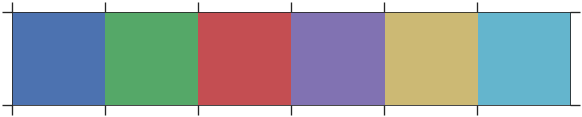

In [7]:
colors = sns.color_palette()
sns.palplot(colors)

In [8]:
def plot_tract_length_distribution(ax):

    sns.despine(ax=ax, offset=5)
    data = [
        df_nco.tract_length_min.loc[df_nco.tract_is_complex].values,
        df_nco.tract_length_min.loc[~df_nco.tract_is_complex].values,
    ]
    bin_edges = np.logspace(2, 4.5, 15)
    ax.hist(data, bins=bin_edges, stacked=True, color=[colors[2], colors[0]], rwidth=1, label=['complex', 'simple'])
    ax.set_xscale('log')
    ax.set_xlabel('minimal tract length (bp)')
    ax.set_ylabel('frequency')
    ax.autoscale(axis='y', tight=True)

    ax2 = ax.twinx()
    sns.despine(ax=ax2, offset=5)
    bin_edges = np.logspace(2, 4.5, 40)
    Z = df_nco_sim.tract_length_min[(df_nco_sim.tract_support > 1) & (df_nco_sim.tract_length_min > 100)].values
    Y, _ = np.histogram(Z, bins=bin_edges)
    X = (bin_edges[1:] + bin_edges[:-1])/2
    ax2.plot(X, Y, color='k', linewidth=1, linestyle='--')
    ax2.autoscale(axis='y', tight=True)
    ax2.set_yticks([])


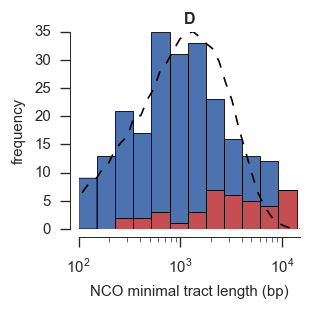

In [9]:
width = 8/3
height = width
fig, ax = plt.subplots(figsize=(width, height))
plot_tract_length_distribution(ax)
ax.set_xlim(100, 15000)
ax.set_xlabel('NCO minimal tract length (bp)')
ax.set_title('D', fontweight='bold')
fig.tight_layout()
fig.savefig('../../artwork/main/fig3D.jpg', dpi=900, jpeg_quality=100)

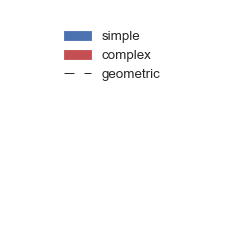

In [10]:
from matplotlib.patches import Patch
fig, ax = plt.subplots(figsize=(2, 2))
ax.set_axis_off()
handles = []
handles.append(Patch(color=colors[0], label='simple'))
handles.append(Patch(color=colors[2], label='complex'))
handles.append(plt.Line2D((0, 0), (1, 1), linestyle='--', marker=' ', color='k', label='geometric'))
ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(0, 1), numpoints=1, fontsize=8, frameon=False, framealpha=.5);
fig.tight_layout()
fig.savefig('../../artwork/main/fig3D_legend.jpg', dpi=900, jpeg_quality=100)

In [11]:
def plot_tract_length_pp(ax, percentiles=range(0, 100, 4), vmax=15000, scatter_kws=dict()):

    sns.despine(ax=ax, offset=5)
    X = df_nco.tract_length_min.values
    Y = df_nco_sim.tract_length_min[(df_nco_sim.tract_support > 1) & (df_nco_sim.tract_length_min > 100)].values
    px = np.array([np.percentile(X, p) for p in percentiles])
    py = np.array([np.percentile(Y, p) for p in percentiles])
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.plot([1, vmax], [1, vmax], color='k', linestyle=':', marker=' ')
    ax.scatter(px, py, **scatter_kws)
    ax.set_xlim(0, vmax)
    ax.set_ylim(0, vmax)
    ax.set_xlim(100, vmax)
    ax.set_ylim(100, vmax)
#    ax.grid(axis='both', which='both')
    

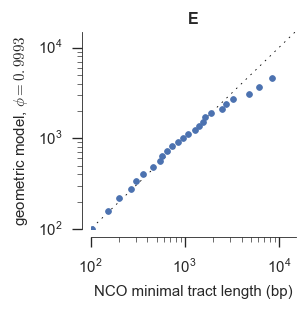

In [12]:
width = 8/3
height = width
fig, ax = plt.subplots(figsize=(width, height))
plot_tract_length_pp(ax, scatter_kws=dict(s=12, marker='o', color=colors[0], zorder=10))
ax.set_xlabel('NCO minimal tract length (bp)')
ax.set_ylabel('geometric model, $\phi = 0.9993$')
ax.set_title('E', fontweight='bold')
fig.tight_layout()
fig.savefig('../../artwork/main/fig3E.jpg', dpi=900, jpeg_quality=100)

In [13]:
X = df_nco.tract_length_min.values
print(stats.percentileofscore(X, 1000))
print(stats.percentileofscore(X, 2000))

50.0
72.6086956522


## NCO recombination rate

In [14]:
tbl_nco_adjusted = (
    tbl_nco
    .valuecounts('cross')
    .cutout('frequency')
    .rename('count', 'n_obs')
    .addfield('n_progeny', lambda row: len(progeny[row.cross]), index=1)
    .addfield('rate_obs', lambda row: row.n_obs / row.n_progeny)
    .addfield('n_adj', lambda row: row.n_obs / nco_discovery_rate[row.cross])
    .addfield('rate_adj', lambda row: row.n_adj / row.n_progeny)
    .addfield('rate_adj_stderr', lambda row: np.sqrt(row.rate_adj / row.n_progeny))
    .addfield('rate_adj_95ci', lambda row: row.rate_adj_stderr * 1.96)
)
tbl_nco_adjusted.display(caption='NCO events by cross')

0|cross,1|n_progeny,2|n_obs,3|rate_obs,4|n_adj,5|rate_adj,6|rate_adj_stderr,7|rate_adj_95ci
hb3_dd2,34,111,3.264705882352941,275.6756756756757,8.108108108108109,0.488337760045,0.957142009688
7g8_gb4,27,77,2.8518518518518516,195.64849146449342,7.246240424610868,0.518053351486,1.01538456891
3d7_hb3,15,42,2.8,91.9869174161897,6.132461161079314,0.63939873637,1.25322152329


In [15]:
n_nco_adj = tbl_nco_adjusted.values('n_adj').sum()
print('#NCOs:', n_nco_adj)

n = np.sum(len(s) for s in progeny.values())
# N.B., some samples have 0 NCOs
print('meioses:', n)

mu_adj_hat = n_nco_adj / n
print('recombination rate: %.2f' % mu_adj_hat, 'NCO/meiosis')

mu_adj_stderr = np.sqrt(mu_adj_hat / n)
print('recombination rate stderr:', mu_adj_stderr)

mu_adj_95ci = 1.96 * mu_adj_stderr
print('recombination rate 95%% CI: %.2f - %.2f' % (mu_adj_hat - mu_adj_95ci, mu_adj_hat + mu_adj_95ci))

#NCOs: 563.3110845563588
meioses: 76
recombination rate: 7.41 NCO/meiosis
recombination rate stderr: 0.31229178231
recombination rate 95% CI: 6.80 - 8.02


In [16]:
# calculate marker span using accessibility regions, it's fairer and simpler
# N.B., here we **exclude** internal hypervariable regions from the total marker span, because NCOs within them will be hidden.
tbl_marker_span = (
    tbl_regions_1b
    .eq('region_type', 'Core')
    .aggregate('region_chrom', sum, 'region_size')
    .rename(dict(region_chrom='chrom', value='span'))
)

total_marker_span = tbl_marker_span.values('span').sum()
lkp_marker_span = tbl_marker_span.lookupone('chrom', 'span')
tbl_marker_span.displayall(caption='Core genome span (total = %.2f)' % (total_marker_span/1e6))


0|chrom,1|span
Pf3D7_01_v3,480620
Pf3D7_02_v3,753550
Pf3D7_03_v3,929971
Pf3D7_04_v3,932894
Pf3D7_05_v3,1281978
Pf3D7_06_v3,1200478
Pf3D7_07_v3,1204739
Pf3D7_08_v3,1249936
Pf3D7_09_v3,1392114
Pf3D7_10_v3,1502845


In [17]:
nco_adj_hat = (mu_adj_hat / (total_marker_span / 1e6))
print('NCO rate (adjusted): %.4f NCO / meiosis / Mb' % nco_adj_hat)
nco_adj_95ci = (mu_adj_95ci / (total_marker_span / 1e6))
print('NCO rate (adjusted) 95%% CI: %.4f - %.4f' % (nco_adj_hat - nco_adj_95ci, nco_adj_hat + nco_adj_95ci))

NCO rate (adjusted): 0.3567 NCO / meiosis / Mb
NCO rate (adjusted) 95% CI: 0.3272 - 0.3861


## NCO rate by chromosome

In [18]:
lkp_nco_sample_chrom = (
    tbl_nco
    .valuecounter('sample', 'chrom')
#    .lookupone('value', 'count')
)
lkp_nco_sample_chrom

Counter({('1BB5/PG0023-C/ERR015449', b'Pf3D7_02_v3'): 1,
         ('1BB5/PG0023-C/ERR015449', b'Pf3D7_08_v3'): 1,
         ('1BB5/PG0023-C/ERR015449', b'Pf3D7_09_v3'): 1,
         ('1BB5/PG0023-C/ERR015449', b'Pf3D7_12_v3'): 1,
         ('1BB5/PG0023-C/ERR015449', b'Pf3D7_13_v3'): 1,
         ('1BB5/PG0023-C/ERR015449', b'Pf3D7_14_v3'): 1,
         ('3BA6/PG0022-Cx/ERR126027', b'Pf3D7_02_v3'): 1,
         ('3BA6/PG0022-Cx/ERR126027', b'Pf3D7_06_v3'): 1,
         ('3BA6/PG0022-Cx/ERR126027', b'Pf3D7_07_v3'): 2,
         ('3BA6/PG0022-Cx/ERR126027', b'Pf3D7_12_v3'): 1,
         ('3BA6/PG0022-Cx/ERR126027', b'Pf3D7_14_v3'): 1,
         ('3BD5/PG0024-C/ERR019053', b'Pf3D7_10_v3'): 1,
         ('3BD5/PG0024-C/ERR019053', b'Pf3D7_12_v3'): 1,
         ('7C101/PG0074-C/ERR019048', b'Pf3D7_06_v3'): 1,
         ('7C101/PG0074-C/ERR019048', b'Pf3D7_13_v3'): 1,
         ('7C101/PG0074-C/ERR019048', b'Pf3D7_14_v3'): 1,
         ('7C111/PG0038-C/ERR015457', b'Pf3D7_03_v3'): 1,
         ('7C111/PG003

In [19]:
tbl_nco_chrom = [['cross', 'sample', 'chrom', 'n_obs']]
for cross in CROSSES:
    for sample in progeny[cross]:
        for chrom in CHROMOSOMES:
            tbl_nco_chrom.append([cross, sample, chrom, lkp_nco_sample_chrom.get((sample, chrom), 0)])
tbl_nco_chrom = (etl
    .wrap(tbl_nco_chrom)
    .addfield('n_adj', lambda row: row.n_obs / nco_discovery_rate[row.cross])
    .addfield('span', lambda row: lkp_marker_span[str(row.chrom, 'ascii')])
)
tbl_nco_chrom.display(20)

0|cross,1|sample,2|chrom,3|n_obs,4|n_adj,5|span
3d7_hb3,C01/PG0065-C/ERR019064,b'Pf3D7_01_v3',0,0.0,480620
3d7_hb3,C01/PG0065-C/ERR019064,b'Pf3D7_02_v3',0,0.0,753550
3d7_hb3,C01/PG0065-C/ERR019064,b'Pf3D7_03_v3',0,0.0,929971
3d7_hb3,C01/PG0065-C/ERR019064,b'Pf3D7_04_v3',0,0.0,932894
3d7_hb3,C01/PG0065-C/ERR019064,b'Pf3D7_05_v3',0,0.0,1281978
3d7_hb3,C01/PG0065-C/ERR019064,b'Pf3D7_06_v3',1,2.190164700385469,1200478
3d7_hb3,C01/PG0065-C/ERR019064,b'Pf3D7_07_v3',0,0.0,1204739
3d7_hb3,C01/PG0065-C/ERR019064,b'Pf3D7_08_v3',0,0.0,1249936
3d7_hb3,C01/PG0065-C/ERR019064,b'Pf3D7_09_v3',0,0.0,1392114
3d7_hb3,C01/PG0065-C/ERR019064,b'Pf3D7_10_v3',1,2.190164700385469,1502845


In [20]:
def plot_nco_rate_by_chrom(ax, scatter_kws=dict()):
    df_nco_chrom = tbl_nco_chrom.todataframe()
    sns.despine(ax=ax)
    sns.offset_spines(ax=ax)
    sns.regplot('span', 'n_adj', df_nco_chrom, x_estimator=np.mean, ax=ax, scatter_kws=scatter_kws)


/usr/local/lib/python3.5/dist-packages/seaborn/utils.py:260: UserWarning: `offset_spines` is deprecated and will be removed in v0.5
  warnings.warn(warn_msg, UserWarning)


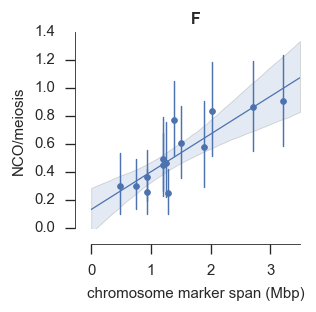

In [21]:
width = 8/3
height = width
fig, ax = plt.subplots(figsize=(width, height))
plot_nco_rate_by_chrom(ax, scatter_kws=dict(s=12))
ax.set_title('F', fontweight='bold')
ax.set_xticks(range(0, 3500000, 1000000))
ax.set_xticklabels(range(0, 4, 1))
ax.set_xlabel('chromosome marker span (Mbp)')
ax.set_ylim(0, 1.4)
ax.set_ylabel('NCO/meiosis')
fig.tight_layout()
fig.savefig('../../artwork/main/fig3F.jpg', dpi=900, jpeg_quality=100)

## Long tracts

In [22]:
tbl_nco_long = (etl
    .frompickle(os.path.join(PUBLIC_DIR, 'tbl_conversion_tracts.pickle'))
    .eq('tract_type', 'NCO')
    .ge('tract_length_min', 18000)
)
tbl_nco_long.displayall()

0|sample,1|cross,2|chrom,3|tract_start_min,4|tract_start_mid,5|tract_start_max,6|tract_stop_min,7|tract_stop_mid,8|tract_stop_max,9|tract_length_min,10|tract_length_mid,11|tract_length_max,12|tract_support,13|tract_is_complex,14|tract_blocks,15|co_pos_mid,16|co_pos_min,17|co_pos_max,18|co_pos_range,19|tract_type
3BD5/PG0024-C/ERR019053,hb3_dd2,b'Pf3D7_10_v3',1308754,1309392,1310031,1330511,1330807,1331104,20480,21415,22350,39,True,3,None,None,None,None,NCO
7C3/PG0034-C/ERR019047,hb3_dd2,b'Pf3D7_08_v3',1202631,1203122,1203613,1227264,1227421,1227578,23651,24299,24947,44,True,5,None,None,None,None,NCO
C04/PG0061-C/ERR019059,3d7_hb3,b'Pf3D7_14_v3',2891817,2892879,2893941,2922794,2923016,2923239,28853,30137,31422,77,True,9,None,None,None,None,NCO
JF6/PG0079-C/ERR027102,7g8_gb4,b'Pf3D7_11_v3',1685640,1686586,1687533,1713449,1713727,1714005,25916,27141,28365,40,True,7,None,None,None,None,NCO
JF6/PG0079-C/ERR027102,7g8_gb4,b'Pf3D7_11_v3',1726074,1726125,1726177,1746099,1747010,1747922,19922,20885,21848,42,True,11,None,None,None,None,NCO
